In [1]:
import numpy as np
from scipy import linalg
import pandas as pd
import mne
import matplotlib.pyplot as plt
import seaborn as sb
from data_util import (
    load_subjects,
    load_subject_data,
    load_data,
    euclidean_alignment,
    label_alignment,
)

In [354]:
scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    "nâng chân trái",
    "nâng chân phải",
    "gật đầu",
    "lắc đầu",
    "há miệng",
]

events = [
    "Thinking",
#     "Thinking and Acting",
#     "Resting",
#     "Typing",
]

channels = [
    "Fp1", "Fp2",
    "F7", "F3", "Fz", "F4", "F8",
    "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
    "T7", "C3", "Cz", "C4", "T8",
    "CP5", "CP1", "CP2", "CP6",
    "P7", "P3", "Pz", "P4", "P8",
    "PO9", "O1", "Oz", "O2", "PO10",
]

label_mapping={
}

n_channels = len(channels)

print(f"using {n_channels} channels")

minimal_trial_duration = 2  # @param
window_duration = 2  # @param
window_stride_duration = 0.2  # @param

fmin = 8.0  # @param
fmax = 30.0  # @param

ds = load_subject_data(
    "../data/vin/Official/K322",
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    fmin=fmin, 
    fmax=fmax, 
    resample=None,
    return_raw=False,
    return_preprocessed=True,
    preload=True,
)

ds_info = ds.description
ds_info

sample: 100%|███████████████████████████████████████████████████████| 9/9 [00:00<00:00, 61.77it/s]

using 32 channels


,scenario
0,nâng tay trái
1,nâng tay phải
2,nâng chân trái
3,nâng chân phải
4,há miệng
5,gật đầu
6,lắc đầu


In [353]:
pd.DataFrame(ds.datasets[5].raw.annotations)

,onset,duration,description,orig_time
0,1.7920,5.5310,Thinking,2021-10-22 11:07:38+00:00
1,7.3229,8.3805,Resting,2021-10-22 11:07:38+00:00
2,15.7044,3.7479,Thinking and Acting,2021-10-22 11:07:38+00:00
3,19.4533,3.3489,Resting,2021-10-22 11:07:38+00:00
4,22.8022,6.2974,Thinking,2021-10-22 11:07:38+00:00
5,29.1007,3.0975,Resting,2021-10-22 11:07:38+00:00
6,32.1992,5.3644,Thinking and Acting,2021-10-22 11:07:38+00:00
7,37.5636,3.2320,Resting,2021-10-22 11:07:38+00:00
8,40.7965,5.6814,Thinking,2021-10-22 11:07:38+00:00
9,46.4780,3.2481,Resting,2021-10-22 11:07:38+00:00


In [11]:
from mne.baseline import rescale
from mne.stats import bootstrap_confidence_interval
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test

In [315]:
freqs = [("alpha", 8, 12), ("beta", 12, 30)]

In [358]:
raw = ds.datasets[0].raw
events, event_id = mne.events_from_annotations(raw)
event_id = {"Resting": event_id["Resting"]}

events

array([[ 1284,     0,     2],
       [ 2041,     0,     1],
       [ 2822,     0,     3],
       [ 3901,     0,     1],
       [ 4543,     0,     2],
       [ 5453,     0,     1],
       [ 6172,     0,     3],
       [ 7181,     0,     1],
       [ 7831,     0,     2],
       [ 8535,     0,     1],
       [ 9260,     0,     3],
       [10292,     0,     1],
       [10874,     0,     4]])

In [359]:
pd.DataFrame(raw.annotations)

,onset,duration,description,orig_time
0,10.0303,5.9150,Thinking,2021-10-22 10:51:52+00:00
1,15.9453,6.0972,Resting,2021-10-22 10:51:52+00:00
2,22.0435,8.4296,Thinking and Acting,2021-10-22 10:51:52+00:00
3,30.4742,5.0151,Resting,2021-10-22 10:51:52+00:00
4,35.4893,7.1140,Thinking,2021-10-22 10:51:52+00:00
5,42.6043,5.6132,Resting,2021-10-22 10:51:52+00:00
6,48.2185,7.8802,Thinking and Acting,2021-10-22 10:51:52+00:00
7,56.0997,5.0806,Resting,2021-10-22 10:51:52+00:00
8,61.1803,5.4981,Thinking,2021-10-22 10:51:52+00:00
9,66.6793,5.6643,Resting,2021-10-22 10:51:52+00:00


In [360]:
epochs = mne.Epochs(raw, events, event_id, tmin=-1, tmax=7, preload=True)
# epochs = mne.concatenate_epochs([ds.datasets[i].windows for i in range(0, 3)])

In [361]:
freq_epochs = list()
for band, fmin, fmax in freqs:
    _epochs = epochs.copy().filter(fmin, fmax, n_jobs=-1)
    _epochs.subtract_evoked()
    _epochs.apply_hilbert(envelope=True)
    freq_epochs.append(_epochs.average())

Text(0.5, 0, 'Time [ms]')

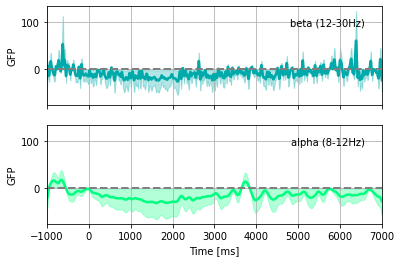

In [363]:
# Helper function for plotting spread
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x ** 2, axis=0)


# Plot
fig, axes = plt.subplots(len(freqs), 1, sharex=True, sharey=True)
colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 4))
for i, (average, color, ax) in enumerate(zip(freq_epochs, colors, axes.ravel()[::-1])):
    band, fmin, fmax = freqs[i]
    times = average.times * 1e3
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=band, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(average.data, random_state=0,
                                                  stat_fun=stat_fun)
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (band, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(-1000, 7000)

axes.ravel()[-1].set_xlabel('Time [ms]')

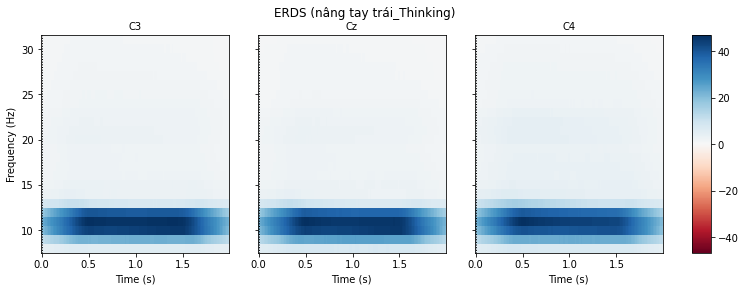

In [350]:
freq_range = np.arange(8, 32)

_epochs = epochs.copy().pick_channels(["C3", "Cz", "C4"], ordered=True)
# _epochs.subtract_evoked()

tfr = tfr_multitaper(_epochs, freqs=freq_range, n_cycles=freq_range, use_fft=True,
                     return_itc=False, average=False, decim=2)

kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type='mask')

for event in _epochs.event_id:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
#         # positive clusters
#         _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
#         # negative clusters
#         _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)
        
        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
#         c = np.stack(c1, axis=2)  # combined clusters
#         p = np.concatenate((p1,))  # combined p-values
#         mask = c[..., p <= 0.05].any(axis=-1)

        _, c, p, _ = pcluster_test(tfr_ev.data[:, ch])

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], cmap="RdBu", axes=ax,
                              colorbar=False, show=False, mask=None,
                              mask_style="mask")
        ax.set_title(_epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1])
    fig.suptitle(f"ERDS ({event})")
    plt.show()

In [2]:
import pickle as pkl

In [29]:
channels = [
    "Fp1", "Fp2",
    "F7", "F3", "Fz", "F4", "F8",
    "FC5", "FC1", "FC2", "FC6",
    "T7", "C3", "Cz", "C4", "T8",
    "CP5", "CP1", "CP2", "CP6",
    "P7", "P3", "Pz", "P4", "P8",
    "O1", "Oz", "O2",
]

In [30]:
with open("../data/beetl/phy_vin_1_40.pkl", mode="rb") as f:
    X, labels, meta = pkl.load(f)["data"]
    X /= 1e6
    meta["label"] = labels
    
meta

,subject,session,run,label
0,1,session_0,run_4,rest
1,1,session_0,run_4,right_hand
2,1,session_0,run_4,rest
3,1,session_0,run_4,left_hand
4,1,session_0,run_4,rest
...,...,...,...,...
14395,40,session_0,run_13,hands
14396,40,session_0,run_13,rest
14397,40,session_0,run_13,feet
14398,40,session_0,run_13,rest


In [31]:
info = mne.create_info(ch_names=channels, sfreq=128.0, ch_types="eeg")

In [60]:
epochs = mne.EpochsArray(X[meta[(meta["subject"] == 1) & (meta["label"] == "left_hand")].index], info)
epochs.set_montage("standard_1020")
len(epochs)

46

In [58]:
def covariance(x):
#     xm = x - x.mean(axis=2, keepdims=True)
#     c = (xm @ xm.transpose((0, 2, 1))) / (xm.shape[2] - 1)
    
#     return c
    return np.stack([np.cov(xi, rowvar=True) for xi in x])

<AxesSubplot:>

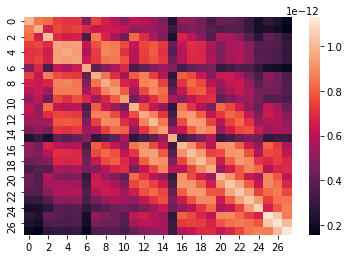

In [61]:
sb.heatmap(covariance(epochs.get_data()).mean(axis=0))

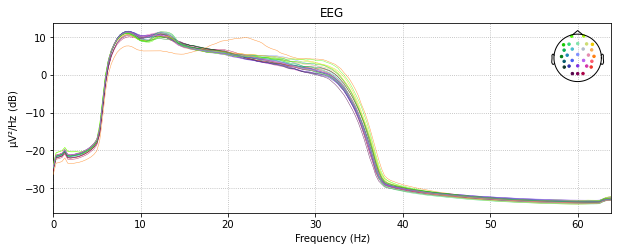

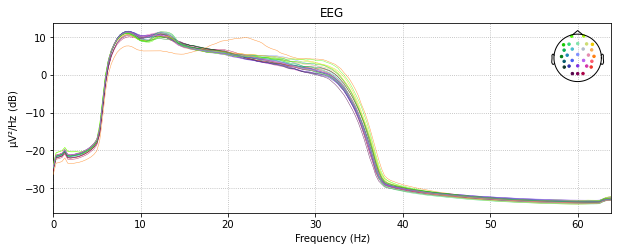

In [56]:
epochs.plot_psd()

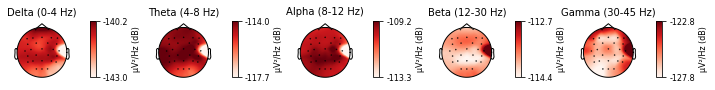

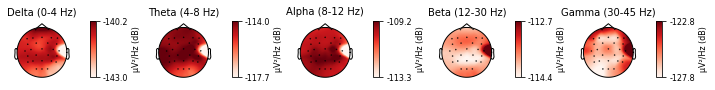

In [57]:
epochs.plot_psd_topomap()

In [16]:
freqs = [("alpha", 8, 12), ("mu", 8, 14), ("beta", 12, 30)]

freq_epochs = list()
for band, fmin, fmax in freqs:
    _epochs = epochs.copy().filter(fmin, fmax, n_jobs=-1)
    _epochs.subtract_evoked()
    _epochs.apply_hilbert(envelope=True)
    freq_epochs.append(_epochs.average())

Text(0.5, 0, 'Time [ms]')

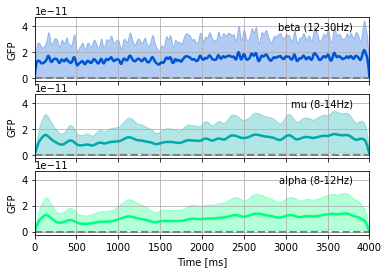

In [17]:
# Helper function for plotting spread
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x ** 2, axis=0)


# Plot
fig, axes = plt.subplots(len(freqs), 1, sharex=True, sharey=True)
colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 4))
for i, (average, color, ax) in enumerate(zip(freq_epochs, colors, axes.ravel()[::-1])):
    band, fmin, fmax = freqs[i]
    times = average.times * 1e3
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=band, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(average.data, random_state=0,
                                                  stat_fun=stat_fun)
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (band, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(0, 4000)

axes.ravel()[-1].set_xlabel('Time [ms]')

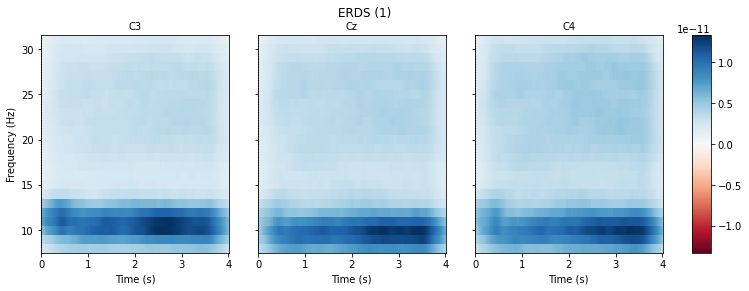

In [18]:
freq_range = np.arange(8, 32)

_epochs = epochs.copy().pick_channels(["C3", "Cz", "C4"], ordered=True)
_epochs.subtract_evoked()

tfr = tfr_multitaper(_epochs, freqs=freq_range, n_cycles=freq_range, use_fft=True,
                     return_itc=False, average=False, decim=2)

kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type='mask')

for event in _epochs.event_id:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
#         # positive clusters
#         _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
#         # negative clusters
#         _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)
        
        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
#         c = np.stack(c1, axis=2)  # combined clusters
#         p = np.concatenate((p1,))  # combined p-values
#         mask = c[..., p <= 0.05].any(axis=-1)

        _, c, p, _ = pcluster_test(tfr_ev.data[:, ch])

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], cmap="RdBu", axes=ax,
                              colorbar=False, show=False, mask=None,
                              mask_style="mask")
        ax.set_title(_epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1])
    fig.suptitle(f"ERDS ({event})")
    plt.show()